## Wordle From Tweeted Scores

Inspired by [Ben Hamner's Kaggle](https://www.kaggle.com/benhamner/wordle-1-6/) and borrowing some methodology, one can predict the wordle of the day from publicly shared scores/guesses.

Differences from the kaggle notebook:

Major differences from above Kaggle notebook:

* **No simulations of hypothetical games.** I do use a similar word commonality lookup dictionary, and the same [word frequency data](https://www.kaggle.com/rtatman/english-word-frequency).
* **No cosine similarity or comparison of specific (e.g. penultimate) guess.** Only the list, and to some extent count, of all tweeted wordle score lines is needed.
* **Slightly different filtering of bad tweets** Upon further reflection, the code now rejects obviously bad tweets. The kaggle data set does some [light filtering](https://www.kaggle.com/benhamner/pull-wordle-tweets). In general, using a minimum count threshold mostly eliminates a few fake or spurious scores that were posted, and the penalty term is small enough that even if the data set has a bunch of retweets of a [tetris pattern](https://twitter.com/TomWritesBlog/status/1489676441562361858), the algorithm still converged accurately. However, non-English wordles or people tweeting out multiple variants at once are both easy to detect so I'm [now removing these](https://github.com/astrowonk/TwitterWordle/commit/98ee732bf50d896e007c01520a95e90dc4edd4a7).
* **100% Accuracy** This algorithm has 100% accuracy from Wordles 210-233 (the original project initially failed on 223, it was successful on later [reruns after some fixes](https://twitter.com/benhamner/status/1489364155370926080). It also failed on 231,236,and 249.) With the restricted target list, `TwitterWordle` is 100% accurate (so far).
  * _Note: Starting on Feb 15, the NY Times removed a few target words from the official wordle list, such as 'papal' and 'agora.' Some people continue to tweet results from the unaltered list, presumably cached/saved versions. So, on Wordle 247, using the full 12,000+ dictionary, `TwitterWordle` did fail to solve correctly. However, the default mode is using the smaller target dictionary._
* **By default, the code only considers the known 2315 possible wordles.** The Kaggle project doesn't give the wordle list special treatment, and runs simulations considering all 12K words as possible answers. While my [wordlebot](https://github.com/astrowonk/wordle) has rolled its own dictionary, I used the actual wordle list here. 
  * Use the keyword argument `use_limited_targets = False` to load precomputed dictionaries across the full 12972 word list, and the `Create Lookup dictionary` notebook can generate this larger set of dictionaries.
  * The code still solves with (almost, see above) 100% accuracy using all 12K+ words, I solve the dataframe using the full list in this notebook at the end.
  * As of Feb 15, 2021 I now use a revised dictionary after [changes made by the New York Times](https://arstechnica.com/gaming/2022/02/heres-how-the-new-york-times-changed-wordle/).


This notebook uses the precomputed dictionaries inside the `TwitterWordle` class to solve a game from tweets. The other notebook generates the dictionaries.



### Basic Solving Methodology

Each target word has a dictionary that maps a wordle line score `10102` (I map 🟩 to 2, 🟨 to 1, and ⬛ and ⬜ to 0.) to how likely that guess is for the target word. To solve:

1. Count and collect the line scores in public tweets. The order doesn't matter.
2. Using some minimum threshold for using the line score, go through every tweeted line score, and sum the average likelihood score for each unique tweeted score line.
3. Subtract a penalty term if the result is impossible for all 12,000 guessable words. For example, only one word ends in 'uery' : query. It is impossible to guess and get `02222` as a result. There for if `02222` occurred in a tweet, the code would subtract a penalty term for `query` as a possible solution.
4. The target word with the maximum summed lookup frequency is the wordle.


Not every penalty term and minimum count is optimal for every wordle. By default the algorithm uses every tweet available (~2000+), requires at least 5 occurences of the line score, and uses -5E7 (around 1 standard deviation of all frequency scores) as penalty. (That makes it sound like I derived the penalty term in some rigorous way. In fact I just tried a bunch of them, -5E7 worked fairly well, then realized for different wordles, the code should iterate on different values until it finds a strong signal.)

If the top answer is less than 10% higher than the runner up, the code iterates through min counts and penalty terms until it finds a prediction that is, or returns the best one.

In [15]:

import plotly.io as pio;# plots should work with matplotlib backend too but ... plotly is better!
pio.renderers.default = "png" #here only for github, for plotly
from TwitterWordle import TwitterWordle
import pandas as pd


### Load in data

`tweets.csv` from the [kaggle project](https://www.kaggle.com/benhamner/wordle-tweets). Storing tweets is [complicated](https://developer.twitter.com/en/developer-terms/agreement-and-policy), so I'm not hosting any tweets in this repository, you should download from there. The dataset filters out some spurious tweets, but I have tested this code on unfiltered tweets collected with [searchtweets](https://pypi.org/project/searchtweets-v2/) which you can see in the subsequent section.

You will need to download from there, as there are various rule on storing tweets (i.e. one must delete them if the account goes private), which requires some automation.

In [16]:

#load in the tweet data from kaggle.
df = pd.read_csv("tweets.csv")
t = TwitterWordle(df)


Loaded 2309 pre-computed lookup dictionaries.


/Users/marcosh/Development/active_projects/TwitterWordle/TwitterWordle.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Solve a Wordle, see a bar graph.

The list of dictionaries is all that is needed to solve from a large number of tweeted results. Below is solving wordle 223, grabbing the tweets from the dataframe `df`. The default parameters are sufficient for most wordles with large N for tweets. The database includes about 2000 or so per tweet.

For wordle 223 below, the default parameters find a very strong signal, so the code does not iterate through other penalty terms and minimum counts.

TwitterWordle analyzed 15094 tweets for Wordle 223.

50756 score patterns. 143 unique.

95.30%, (142/149) valid final guess patterns found. Impossible pattern count: 1.

Wordle 223 prediction: PERKY.
2.5 STD above mean. 1.4 above runner up.



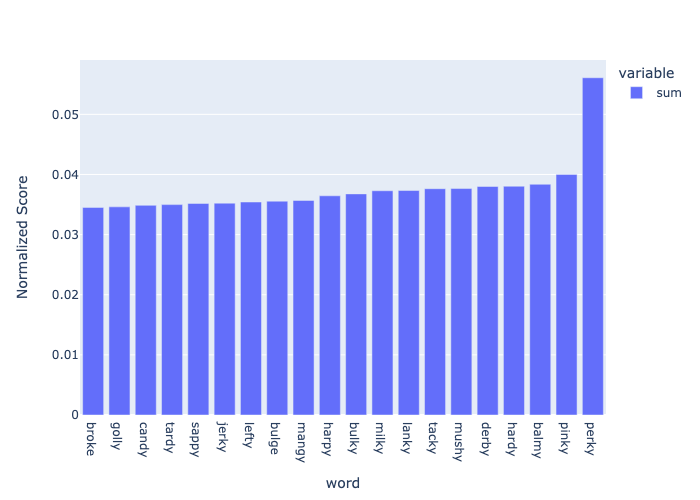

'perky'

In [17]:

t.solve(223,mask_result=False,plot=True)

The penalty term is averaged in when a wordle score line is impossible for a given target word. However, too high and spurious/fake tweets will penalize real possible target words.

With fewer tweets, the likelihood of bogus tweets is lower, and minimum count can be reduced. Wordle 210 again with a downsampled size and a lower min_count. 

**100 tweets is enough (for some words)!** I lower the min count when downsampling, and the alg iterates through penalty terms until the signal means the 10% threshold.

354 score patterns. 75 unique.

Wordle 223 initial signal low 1.01. Iterating for better parameters
...............................................
Iterated to a better signal with min_count 1 and penalty -3.10E+08
50.34%, (75/149) valid final guess patterns found. Impossible pattern count: 0.

Wordle 223 prediction: PERKY.
2.7 STD above mean. 1.11 above runner up.



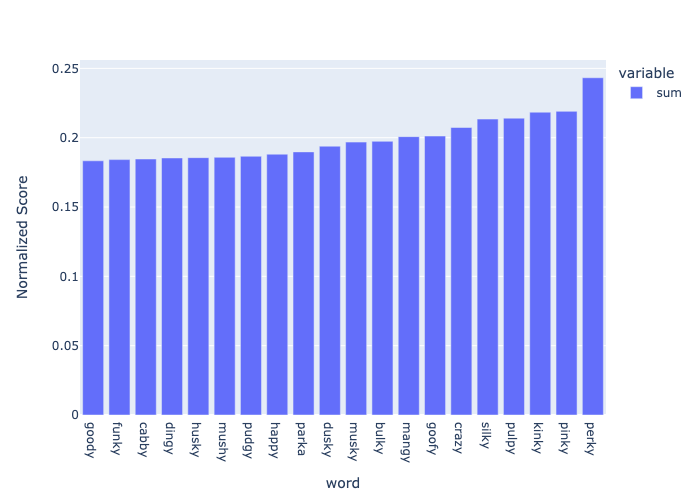

'perky'

In [18]:
#Solve with only 100 tweets
t.solve(223,downsample=100,min_count=1,plot=True,mask_result=False)

### Solve all test wordles in the test dataframe

In [8]:
t.solve_all(mask_result=False)

TwitterWordle analyzed 2724 tweets for Wordle 210.

7677 score patterns. 132 unique.

89.58%, (129/144) valid final guess patterns found. Impossible pattern count: 3.

Wordle 210 prediction: PANIC.
1.8 STD above mean. 1.12 above runner up.

TwitterWordle analyzed 2764 tweets for Wordle 211.

8014 score patterns. 164 unique.

92.49%, (160/173) valid final guess patterns found. Impossible pattern count: 4.

Wordle 211 prediction: SOLAR.
3.2 STD above mean. 1.27 above runner up.

TwitterWordle analyzed 2287 tweets for Wordle 212.

6521 score patterns. 159 unique.

89.66%, (156/174) valid final guess patterns found. Impossible pattern count: 3.

Wordle 212 prediction: SHIRE.
3.3 STD above mean. 1.34 above runner up.

TwitterWordle analyzed 2018 tweets for Wordle 213.

7260 score patterns. 94 unique.

Wordle 213 initial signal low 1.06. Iterating for better parameters
...............................................
Iterated to a better signal with min_count 1 and penalty -1.30E+08
80.00%, (

### Solve with acquired tweets

If you have a Twitter developer account, I have a helper function for [searchtweets](https://pypi.org/project/searchtweets-v2/)  that will pull recent tweets for a given wordle number. It assumes a configuration in `~/.twitter_keys.yaml`.


In [10]:
from get_tweets import get_tweets
tweets = get_tweets(247,return_df=True)
t = TwitterWordle(tweets)
t.solve(247,mask_result=True,plot=True)

Loaded 2309 pre-computed lookup dictionaries.
TwitterWordle analyzed 2864 tweets for Wordle 247.

8195 score patterns. 123 unique.

Wordle 247 initial signal low 1.07. Iterating for better parameters
...

/Users/marcosh/Development/active_projects/TwitterWordle/TwitterWordle.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



...........................................................................................
Iterated to a better signal with min_count 3 and penalty -9.00E+07
84.96%, (113/133) valid final guess patterns found. Impossible pattern count: 10.

Wordle 247 solution hash: d9298a10d1b0735837dc4bd85dac641b0f3cef27a47e5d53a54f2f3f5b2fcffa. 2.3 STD above mean. 1.13 above runner up.

Solution match is TRUE


'd9298a10d1b0735837dc4bd85dac641b0f3cef27a47e5d53a54f2f3f5b2fcffa'

### Solve using the full 12972 length dictionary.

Limiting to the 2315 possible wordle answers likely improves performance, however the code works well considering all 12972 guessable words as possible answers.

In mid-February, 2022, the NY Times removed a few wordle answers and allowable guesses. Specifically, some players continue to play cached/archive versions of the original word list, and 'impossible scores' have become much more common on Twitter, with the majority playing the official Wordle, but a few people playing against a different target word.

The code has been generally robust to this, but raising the min_count may be necessary after 2022-02-15.

In [13]:
t_full_dictionary = TwitterWordle(df,use_limited_targets=False)


Loaded 12945 pre-computed lookup dictionaries.


/Users/marcosh/Development/active_projects/TwitterWordle/TwitterWordle.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
t_full_dictionary.solve_all(mask_result=False)

TwitterWordle analyzed 2724 tweets for Wordle 210.

7677 score patterns. 132 unique.

Wordle 210 initial signal low 1.06. Iterating for better parameters
...............................................
Iterated to a better signal with min_count 1 and penalty -5.70E+08
89.58%, (129/144) valid final guess patterns found. Impossible pattern count: 3.

Wordle 210 prediction: PANIC.
2.9 STD above mean. 1.1 above runner up.

TwitterWordle analyzed 2764 tweets for Wordle 211.

8014 score patterns. 164 unique.

92.49%, (160/173) valid final guess patterns found. Impossible pattern count: 4.

Wordle 211 prediction: SOLAR.
3.1 STD above mean. 1.15 above runner up.

TwitterWordle analyzed 2287 tweets for Wordle 212.

6521 score patterns. 159 unique.

89.66%, (156/174) valid final guess patterns found. Impossible pattern count: 3.

Wordle 212 prediction: SHIRE.
3.5 STD above mean. 1.23 above runner up.

TwitterWordle analyzed 2018 tweets for Wordle 213.

7260 score patterns. 94 unique.

Wordle 213